# Training Procedure

Imports básicos.

In [0]:
import os
import numpy as np
import torch

## Setting data loader

Utilizando o dataset padrão do MNIST disponibilizado pelo pacote torchvision. Para mais informações sobre o dataset, acesse a página: <https://pytorch.org/docs/stable/torchvision/datasets.html#mnist>.

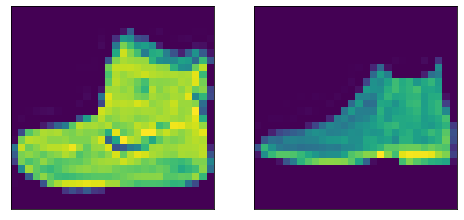

In [8]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

from matplotlib import pyplot as plt

%matplotlib inline

transf = transforms.Compose([transforms.ToTensor()])

train_set = datasets.FashionMNIST('./', transform=transf, train=True, download=True)
test_set = datasets.FashionMNIST('./', transform=transf, train=False, download=False)

# Plotting samples.
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(train_set[0][0].numpy().squeeze())
ax[0].set_yticks([])
ax[0].set_xticks([])

ax[1].imshow(test_set[0][0].numpy().squeeze())
ax[1].set_yticks([])
ax[1].set_xticks([])

plt.show()

In [9]:
# Creating data loaders.
batch_size = 1000

train_loader = DataLoader(train_set, batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

for i, data in enumerate(train_loader):
    
    inps, labs = data
    print(inps.size(), labs.size())
    print('')

    if i > 5:
        break

torch.Size([1000, 1, 28, 28]) torch.Size([1000])

torch.Size([1000, 1, 28, 28]) torch.Size([1000])

torch.Size([1000, 1, 28, 28]) torch.Size([1000])

torch.Size([1000, 1, 28, 28]) torch.Size([1000])

torch.Size([1000, 1, 28, 28]) torch.Size([1000])

torch.Size([1000, 1, 28, 28]) torch.Size([1000])

torch.Size([1000, 1, 28, 28]) torch.Size([1000])



## Setting architecture

Defina a arquitetura da sua Rede Neural. O pacote torch.nn que contém as implementações de todas as camadas que serão usadas nessa parte (nn.Linear): <https://pytorch.org/docs/stable/nn.html>.

In [10]:
import torch.nn as nn

# Random initialization for weights and biases.
def initialize_weights(*models):
    for model in models:
        for module in model.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()

# Customized Network.
class CustomNetwork(nn.Module):
    
    def __init__(self, input_size, n_classes):

        super(CustomNetwork, self).__init__()
        
        ###################################################
        # Neural Network architecture. 4 hidden layers. ###
        ###################################################
        self.n_outputs_1 = 500
        self.n_outputs_2 = 200
        self.n_outputs_3 = 100

        self.drop = nn.Dropout()                                    # Reusable Dropout regularization layer.
        
        self.layer1 = nn.Linear(input_size, self.n_outputs_1)       # Fully Connected Layer: 784 -> 500.
        self.ativ1 = nn.ReLU(inplace=True)                          # ReLU Activation Layer.
        
        self.layer2 = nn.Linear(self.n_outputs_1, self.n_outputs_2) # Fully Connected Layer: 500 -> 200.
        self.ativ2 = nn.ReLU(inplace=True)                          # ReLU Activation Layer.
        
        self.layer3 = nn.Linear(self.n_outputs_2, self.n_outputs_3) # Fully Connected Layer: 200 -> 100.
        self.ativ3 = nn.ReLU(inplace=True)                          # ReLU Activation Layer.
        
        self.layer4 = nn.Linear(self.n_outputs_3, n_classes)        # Fully Connected Layer: 100 -> 10.

    # Forward function.
    def forward(self, x):
        
        ###################################################
        # Forwarding through 1st layer. ###################
        ###################################################
        out = self.layer1(x)
        out = self.drop(self.ativ1(out))
        # print('out', out.size()) # Comment this line for less text during execution.
        
        ###################################################
        # Forwarding through 2nd layer. ###################
        ###################################################
        out = self.layer2(out)
        out = self.drop(self.ativ2(out))
        # print('out', out.size()) # Comment this line for less text during execution.
        
        ###################################################
        # Forwarding through 3rd layer. ###################
        ###################################################
        out = self.layer3(out)
        out = self.drop(self.ativ3(out))
        # print('out', out.size()) # Comment this line for less text during execution.
        
        ###################################################
        # Forwarding through 4th layer. ###################
        ###################################################
        out = self.layer4(out)
        # print('out', out.size()) # Comment this line for less text during execution.
        
        # Returning output.
        return out
        
# Instancing Network.
input_size = 784 # Input size (28*28).
n_classes = 10 # Number of classes on FashionMNIST.

# model = CustomNetwork(input_size) # CPU version.
model = CustomNetwork(input_size, n_classes).cuda() # GPU casting.

initialize_weights(model)

# Printing NN.
print(model)

CustomNetwork(
  (drop): Dropout(p=0.5, inplace=False)
  (layer1): Linear(in_features=784, out_features=500, bias=True)
  (ativ1): ReLU(inplace=True)
  (layer2): Linear(in_features=500, out_features=200, bias=True)
  (ativ2): ReLU(inplace=True)
  (layer3): Linear(in_features=200, out_features=100, bias=True)
  (ativ3): ReLU(inplace=True)
  (layer4): Linear(in_features=100, out_features=10, bias=True)
)


## Setting optimizer

O $Pytorch$ tem várias opções de otimizadores, desde os mais simples como o SGD até adaptadores mais modernos com velocidades de aprendizado adaptáveis para cada parâmetro da rede (i.e. Adam, Adagrad, RSMProp...). Todos os otimizadores estão localizados no pacote torch.optim. Para mais informnações sobre o pacote, visite: <https://pytorch.org/docs/stable/optim.html>.

In [0]:
import torch.optim as optim

lr = 0.001 # Learning rate.
l2_normalization = 0.00005 # L2 Normalization via weight decay.

optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=l2_normalization)

## Setting loss criterion

Definindo um critério (loss) de classificação para calcular o erro do seu modelo a cada batch de amostras. A $CrossEntropyLoss$ ou a $NLLLoss$ são funções de perda indicadas para esse tipo de tarefa. Informações sobre essas losses podem ser encontradas em: <https://pytorch.org/docs/stable/nn.html#loss-functions>. 

In [0]:
# Setting classification loss.
# criterion = nn.CrossEntropyLoss() # CPU version.
criterion = nn.CrossEntropyLoss().cuda() # GPU casting.

## Training/Testing

Iterando sobre batches de treino e teste ao longo de várias epochs.

In [13]:
from matplotlib import pyplot as plt
from torch.autograd import Variable

%matplotlib inline

epochs = 10 # Number of training and testing epochs.

training_metrics = list() # List for accuracies in training procedure.
test_metrics = list() # List for accuracies in test procedure.

# Iterating over epochs.
for ep in range(epochs):
    
    print('##############################################')
    print('Starting epoch ' + str(ep + 1) + '/' + str(epochs) + '...')
    
    #####################################################################
    # Training Procedure. ###############################################
    #####################################################################
    
    print('    Training...')
    
    # Setting model to training mode.
    model.train()
    
    # Iterating over training batches.
    for it, data in enumerate(train_loader):

        # Obtaining data and labels for batch.
        inps, labs = data
        
        # GPU casting. In CPU version comment the following two lines.
        inps = inps.cuda()
        labs = labs.cuda()
        
        # Zeroing optimizer.
        optimizer.zero_grad()
        
        # Forwarding inps through NN.
        output = model(inps.view(inps.size(0), -1))
        
        # Computing loss according to network prediction for batch and targets.
        loss = criterion(output, labs)
        
        # Backpropagating loss.
        loss.backward() # All backward pass is computed from this line automatically by package torch.autograd.
        
        # Taking optimization step (updating NN weights).
        optimizer.step()
        
        # Appending metric for batch.
        training_metrics.append(loss.mean())

    #####################################################################
    # Testing Procedure.  ###############################################
    #####################################################################
    
    print('    Testing...')
    
    # Setting model to evaluation mode.
    model.eval()

    with torch.no_grad():

        label_list = list()
        output_list = list()

        # Iterating over test batches.
        for it, data in enumerate(test_loader):
            
            # Obtaining images and labels for batch.
            inps, labs = data
            
            # GPU casting. In CPU version comment the following line.
            inps = inps.cuda()
            labs = labs.cuda()
            
            # Forwarding inps through NN.
            output = model(inps.view(inps.size(0), -1))
            
            # Computing loss according to network prediction for batch and targets.
            loss = criterion(output, labs)

            # Appending metric for batch.
            test_metrics.append(loss.mean())

            # Getting labels and predictions from last epoch.
            label_list += labs.cpu().numpy().tolist()
            output_list += output.max(1)[1].cpu().numpy().tolist()

        label_array = np.asarray(label_list, dtype=np.int).ravel()
        output_array = np.asarray(output_list, dtype=np.int).ravel()

        print('Epoch: %d, Accuracy: %.2f%%' % (ep + 1, 100.0 * np.sum(label_array == output_array) / float(label_array.shape[0])))

##############################################
Starting epoch 1/10...
    Training...
    Testing...
Epoch: 1, Accuracy: 76.81%
##############################################
Starting epoch 2/10...
    Training...
    Testing...
Epoch: 2, Accuracy: 81.95%
##############################################
Starting epoch 3/10...
    Training...
    Testing...
Epoch: 3, Accuracy: 83.68%
##############################################
Starting epoch 4/10...
    Training...
    Testing...
Epoch: 4, Accuracy: 84.97%
##############################################
Starting epoch 5/10...
    Training...
    Testing...
Epoch: 5, Accuracy: 85.67%
##############################################
Starting epoch 6/10...
    Training...
    Testing...
Epoch: 6, Accuracy: 85.38%
##############################################
Starting epoch 7/10...
    Training...
    Testing...
Epoch: 7, Accuracy: 86.17%
##############################################
Starting epoch 8/10...
    Training...
    Testing...
Epo

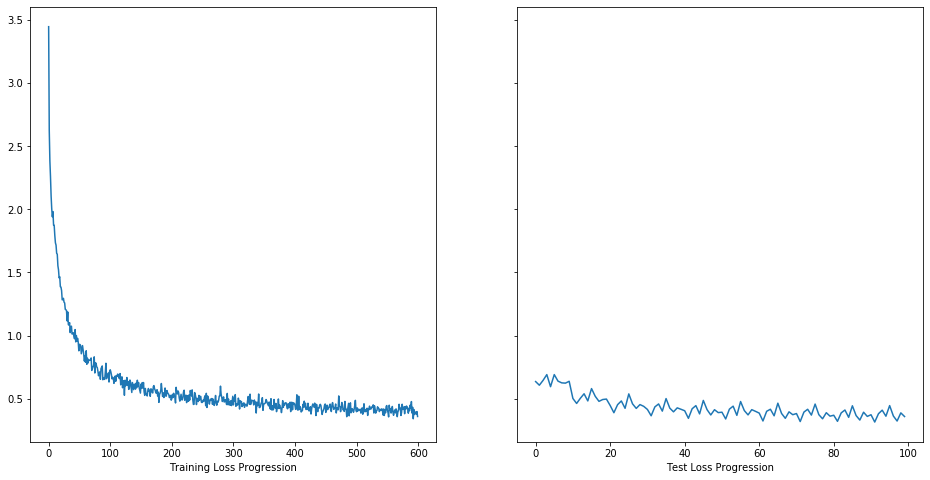

Actual: 9.0000, Predicted: 9.0000
Actual: 2.0000, Predicted: 2.0000
Actual: 1.0000, Predicted: 1.0000
Actual: 1.0000, Predicted: 1.0000
Actual: 6.0000, Predicted: 6.0000
Actual: 1.0000, Predicted: 1.0000
Actual: 4.0000, Predicted: 4.0000
Actual: 6.0000, Predicted: 6.0000
Actual: 5.0000, Predicted: 5.0000
Actual: 7.0000, Predicted: 7.0000


In [14]:
# Transforming list into ndarray for plotting.
training_array = np.asarray(training_metrics, dtype=np.float32)
test_array = np.asarray(test_metrics, dtype=np.float32)

# Plotting error metric.
fig, ax = plt.subplots(1, 2, figsize = (16, 8), sharex=False, sharey=True)

ax[0].plot(training_array)
ax[0].set_xlabel('Training Loss Progression')

ax[1].plot(test_array)
ax[1].set_xlabel('Test Loss Progression')

plt.show()

for i in range(10):
    print('Actual: %.4f, Predicted: %.4f' % (label_array[i], output_array[i]))